In [1]:
# librerias

import warnings
warnings.filterwarnings('ignore')


import pylab as plt
import pandas as pd
import seaborn as sns


from keras.utils import get_file

from keras import Sequential
from keras.layers import Dense

from keras.callbacks import Callback, EarlyStopping

from tensorflow.keras.optimizers.legacy import RMSprop

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from datetime import date, time, datetime, timedelta

# Preparación del dataset  
Las columnas tienen los siguientes significados:  
- status (Housing status - a. ready for sale or b. ready to build)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)
- price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)

In [2]:
df_realtor = pd.read_csv('realtor-data.csv')

In [3]:
df_realtor.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [4]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        512159 non-null  object 
 1   price         512159 non-null  float64
 2   bed           413222 non-null  float64
 3   bath          416941 non-null  float64
 4   acre_lot      407180 non-null  float64
 5   full_address  512159 non-null  object 
 6   street        511543 non-null  object 
 7   city          512100 non-null  object 
 8   state         512159 non-null  object 
 9   zip_code      511962 non-null  float64
 10  house_size    395693 non-null  float64
 11  sold_date     202507 non-null  object 
dtypes: float64(6), object(6)
memory usage: 46.9+ MB


Vamos a eliminar las columnas full_address, street y city puesto que esa info es redundante con la información que nos ofrece la columna State

In [5]:
df_realtor.drop('full_address', axis=1, inplace=True)
df_realtor.drop('street', axis=1, inplace=True)
df_realtor.drop('city', axis=1, inplace=True)
df_realtor.drop('zip_code', axis=1, inplace=True)

Cambiamos la columna sold_date a formato fecha

In [6]:
df_realtor['sold_date'] = pd.to_datetime(df_realtor['sold_date'], format='%Y-%m-%d', errors='coerce')

In [7]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   status      512159 non-null  object        
 1   price       512159 non-null  float64       
 2   bed         413222 non-null  float64       
 3   bath        416941 non-null  float64       
 4   acre_lot    407180 non-null  float64       
 5   state       512159 non-null  object        
 6   house_size  395693 non-null  float64       
 7   sold_date   202507 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 31.3+ MB


Eliminamos nulos

In [8]:
df_realtor.dropna(inplace=True)

In [9]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141669 entries, 829 to 512154
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   status      141669 non-null  object        
 1   price       141669 non-null  float64       
 2   bed         141669 non-null  float64       
 3   bath        141669 non-null  float64       
 4   acre_lot    141669 non-null  float64       
 5   state       141669 non-null  object        
 6   house_size  141669 non-null  float64       
 7   sold_date   141669 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 9.7+ MB


Creamos una nueva columna con el año de venta

In [10]:
def anio(x):
    return x.year
df_realtor['sold_year'] = df_realtor['sold_date'].apply(anio)

Creamos una nueva columna con las estaciones del año

In [11]:
def estaciones(x):
    dia_mes = datetime(x.year, x.month, x.day)

    primavera = datetime(x.year, 3, 21)
    verano = datetime(x.year, 6, 21)
    otoño = datetime(x.year, 9, 21)
    invierno = datetime(x.year, 12, 21)

    if primavera <= dia_mes < verano:
        return 'spring'
    elif verano <= dia_mes < otoño:
        return 'summer'
    elif otoño <= dia_mes < invierno:
        return 'autumn'
    else:  
        return 'winter'

df_realtor['sold_season'] = df_realtor['sold_date'].apply(estaciones)

Vemos como queda el dataset

In [12]:
df_realtor.head()

,status,price,bed,bath,acre_lot,state,house_size,sold_date,sold_year,sold_season
829,for_sale,110000.0,7.0,3.0,0.09,Puerto Rico,1192.0,2019-06-28,2019,summer
3380,for_sale,110000.0,7.0,3.0,0.09,Puerto Rico,1192.0,2019-06-28,2019,summer
5083,for_sale,110000.0,7.0,3.0,0.09,Puerto Rico,1192.0,2019-06-28,2019,summer
5387,for_sale,110000.0,7.0,3.0,0.09,Puerto Rico,1192.0,2019-06-28,2019,summer
9053,for_sale,110000.0,7.0,3.0,0.09,Puerto Rico,1192.0,2019-06-28,2019,summer


Vamos a observar las variables categóricas que nos quedan

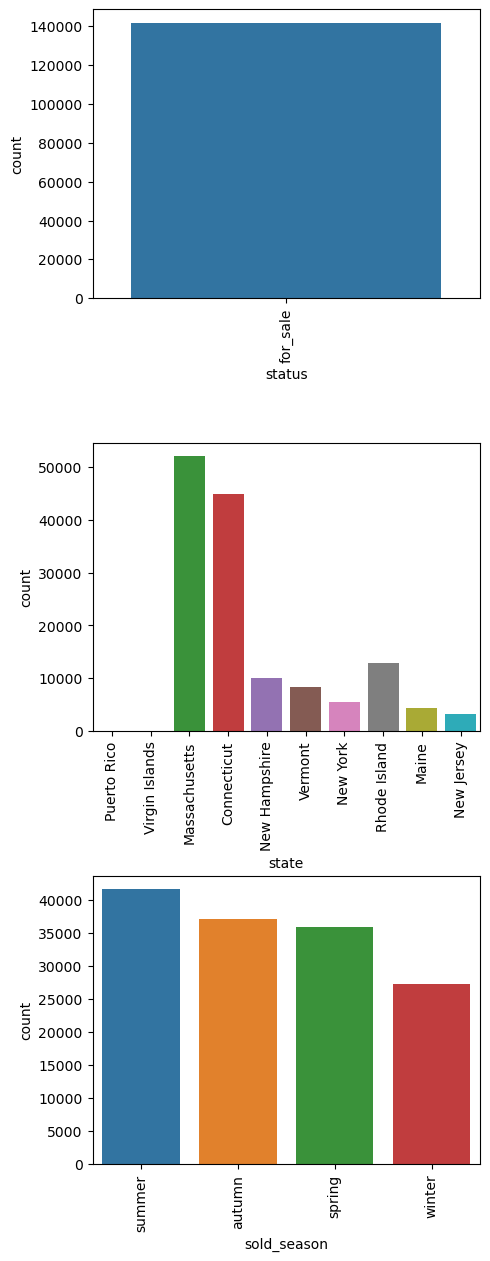

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['status','state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

Eliminamos status, porque al eliminar todas las casas sin fecha de venta, hemos eliminado las casas con la categoría ready to build.  
Esto significa que en EEUU no suelen venderse muchas casas sobre plano, es decir que no están construidas.

In [14]:
df_realtor.drop('status', axis=1, inplace=True)

In [15]:
df_realtor.state.value_counts()

Massachusetts     51961
Connecticut       44923
Rhode Island      12996
New Hampshire     10163
Vermont            8381
New York           5617
Maine              4421
New Jersey         3181
Puerto Rico          20
Virgin Islands        6
Name: state, dtype: int64

Puerto Rico y las Islas Vírgenes están en el Caribe. Vamos a crear un nuevo valor que sea Caribbean States

In [16]:
def agrupacion(x):
    if x == 'Virgin Islands':
        return 'Caribbean states'
    elif x == 'Puerto Rico':
        return 'Caribbean states'
    else:
        return x
df_realtor['state']=df_realtor['state'].apply(agrupacion)

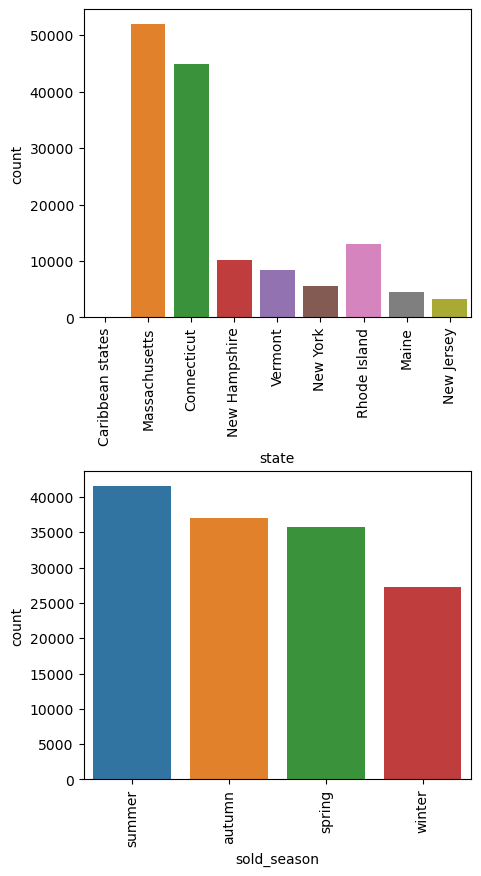

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(['state','sold_season']):
  sns.countplot(x=col, data=df_realtor, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)